<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/learn/nonmem/eta_eps_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Calculate eta for one-compartment iv model

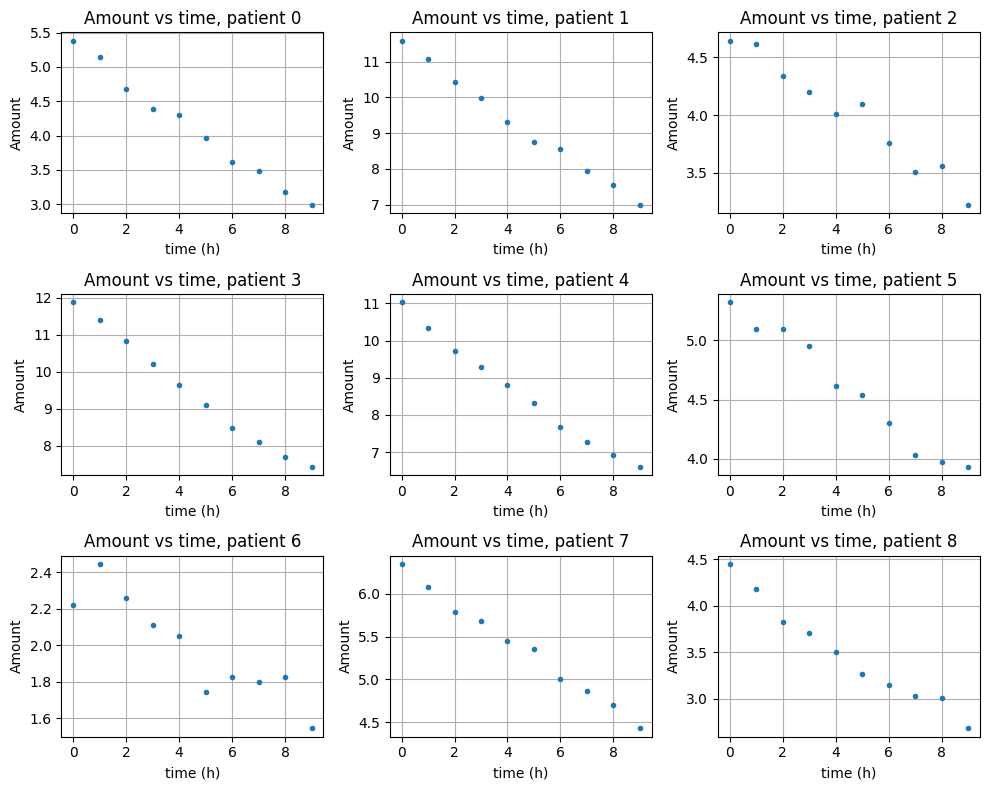

In [51]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (3.5, 3)

# Simulated data
np.random.seed(42)
n_patients = 20
n_obs = 10

# Population parameters
pop_cl = 1.0  # Population clearance
pop_v = 20.0  # Population volume

# Variance of random effects (eta)
omega_cl = 0.2  # Variance for clearance
omega_v = 0.2   # Variance for volume

sigma = 0.1

# Simulate data
data = []
for patient in range(n_patients):
    eta_cl = np.random.normal(0, np.sqrt(omega_cl)) # Random effect of clearance
    eta_v = np.random.normal(0, np.sqrt(omega_v))   # Random effect for volume
    for t in range(n_obs):
        dose = 100  # Dose amount
        time = t  # Time in hours
        # Simple PK model: C(t) = Dose / V * e^(-Cl/V * t)
        concentration = (dose / (pop_v * np.exp(eta_v))) * np.exp(
                            -((pop_cl * np.exp(eta_cl)) / (pop_v)) * time)
        # Add some observation error
        concentration += np.random.normal(0, sigma)  # Adding Gaussian noise
        data.append([patient, time, concentration])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['patient', 'time', 'concentration'])

fig, axs = plt.subplots(3,3, figsize=(10, 8))

for i in range(3):
    for j in range(3):
        unique_id = i*3 + j

        # print(unique_id)
        data_single = df[df['patient'] == unique_id]
        t = data_single['time']
        true_y = data_single['concentration']
        # pred_y = data_single['preds']
        # axs[i, j].plot(t, true_y, t, pred_y, 'g--')
        axs[i, j].plot(t, true_y, '.')
        axs[i, j].set_title(f'Amount vs time, patient {unique_id}')
        axs[i, j].set_xlabel('time (h)')
        axs[i, j].set_ylabel('Amount')
        axs[i, j].grid(True)

plt.xlabel('time (h)')
plt.ylabel('Amount')
# plt.legend(['True A', 'Pred A'])
plt.tight_layout()
plt.show()


NLL: negative log-likelihood

$\text{NLL} = \sum \left[\frac{(y_{obs}- y_{pred})^2}{2\sigma^2} + \log (\sigma \sqrt{2\pi})\right]$

In [52]:
# Define the objective function to minimize
def objective(params, df):
    cl, v, omega_cl, omega_v, sigma = params
    nll = 0  # Negative log-likelihood
    for patient in df['patient'].unique():
        patient_data = df[df['patient'] == patient]
        eta_cl = np.random.normal(0, np.sqrt(omega_cl))
        eta_v = np.random.normal(0, np.sqrt(omega_v))
        eps = np.random.normal(0, np.sqrt(epsilon))

        for index, row in patient_data.iterrows():
            time = row['time']
            observed = row['concentration']
            # Model prediction
            pred = (100 / (v * np.exp(eta_v))) * np.exp(
                        -((cl * np.exp(eta_cl)) / (v)) * time)
            # Update the negative log-likelihood (NLL)
            nll += ((observed - pred)**2) / (2 * sigma**2) \
                    + np.log(sigma * np.sqrt(2 * np.pi))

    return nll
# Initial parameter guesses
initial_params = [1.0, 5.0, 0.1, 0.1, 0.1]  # [cl, v, omega_cl, omega_v, sigma]

# # Minimize the objective function
# result = minimize(objective, initial_params, args=(df,),
#               bounds=((0, None), (0, None), (0, None), (0, None), (0, None)))
result = minimize(objective, initial_params, args=(df,),
                  method='Nelder-Mead',  # Gradient-free optimizer
                  options={'maxiter': 1000, 'disp': True})  # Increase iterations if needed

# Output the results
estimated_params = result.x
print("Estimated Parameters:")
print(f"Clearance: {estimated_params[0]}")
print(f"Volume: {estimated_params[1]}")
print(f"Omega Clearance: {estimated_params[2]}")
print(f"Omega Volume: {estimated_params[3]}")
print(f"Var epsilon: {estimated_params[4]}")


Estimated Parameters:
Clearance: 1.0068000000000017
Volume: 5.0340000000001135
Omega Clearance: 0.10068000000000438
Omega Volume: 0.09347999999999679
Var epsilon: 0.10068000000000987


<ipython-input-52-b55e8ac1c65e>:26: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(objective, initial_params, args=(df,),


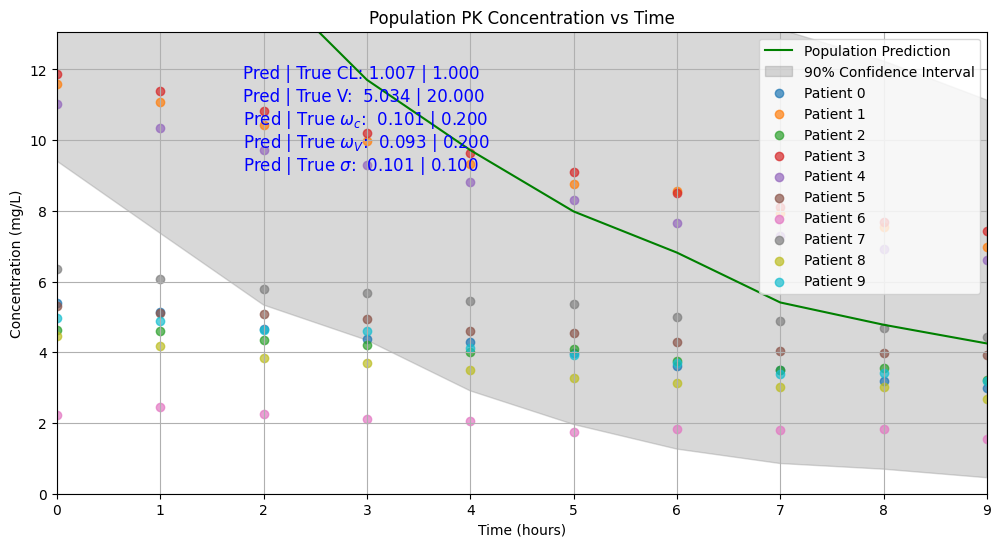

In [53]:
import seaborn as sns


# Create a time vector for predictions
time_vector = np.linspace(0, 9, 100)  # Time from 0 to 9 hours
pop_cl_pred = estimated_params[0]
pop_v_pred = estimated_params[1]
omega_cl_pred = estimated_params[2]
omega_v_pred = estimated_params[3]
sigma_pred = estimated_params[4]
# Calculate population predictions
# population_predictions = (100 / pop_v_pred) * np.exp(-pop_cl_pred / pop_v_pred * time_vector)

# # Create a DataFrame for population predictions
# pop_pred_df = pd.DataFrame({'time': time_vector, 'population_prediction': population_predictions})

# Plotting
plt.figure(figsize=(12, 6))

# Plot population predictions
# plt.plot(pop_pred_df['time'], pop_pred_df['population_prediction'],
#          label='Population PK Prediction', color='blue', linewidth=2)
# Simulate time points
time_points = np.arange(n_obs)

# Define the population-level PK model and generate predictions
def generate_population_predictions(time_points, pop_cl, pop_v, omega_cl, omega_v):
    pop_predictions = []
    ci_lower = []
    ci_upper = []

    for time in time_points:
        # Simulate the random effects for the population
        eta_cl = np.random.normal(0, np.sqrt(omega_cl), size=1000)  # Draw random effects for clearance
        eta_v = np.random.normal(0, np.sqrt(omega_v), size=1000)    # Draw random effects for volume

        # Population prediction with random effects
        preds = (100 / (pop_v * np.exp(eta_v))) * np.exp(
                        -((pop_cl * np.exp(eta_cl)) / (pop_v)) * time)

        # Calculate the mean prediction for the population
        mean_pred = np.mean(preds)
        pop_predictions.append(mean_pred)

        # Calculate the 90% confidence interval (based on the 5th and 95th percentiles)
        ci_lower.append(np.percentile(preds, 5))
        ci_upper.append(np.percentile(preds, 95))

    return pop_predictions, ci_lower, ci_upper

# Generate the population predictions and 90% confidence intervals
pop_predictions, ci_lower, ci_upper = generate_population_predictions(
            time_points, pop_cl_pred, pop_v_pred, omega_cl, omega_v)



plt.plot(time_points, pop_predictions, label='Population Prediction', color='g')
plt.fill_between(time_points, ci_lower, ci_upper,
                 color='grey', alpha=0.3, label='90% Confidence Interval')



# Plot first 10 individual patient data
for patient in df['patient'].unique()[:10]:
    patient_data = df[df['patient'] == patient]
    plt.scatter(patient_data['time'], patient_data['concentration'],
                label=f'Patient {patient}', alpha=0.7)

# Customize the plot
plt.title('Population PK Concentration vs Time')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (mg/L)')
plt.annotate(f'Pred | True CL: {pop_cl_pred:.3f} | {pop_cl:.3f}', xy=(0.2, 0.9),
             xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'Pred | True V:  {pop_v_pred:.3f} | {pop_v:.3f}', xy=(0.2, 0.85),
             xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'Pred | True $\omega_c$:  {omega_cl_pred:.3f} | {omega_cl:.3f}',
             xy=(0.2, 0.8), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'Pred | True $\omega_V$:  {omega_v_pred:.3f} | {omega_v:.3f}',
             xy=(0.2, 0.75), xycoords='axes fraction', fontsize=12, color='blue')
plt.annotate(f'Pred | True $\sigma$:  {sigma_pred:.3f} | {sigma:.3f}',
             xy=(0.2, 0.7), xycoords='axes fraction', fontsize=12, color='blue')


plt.legend()

plt.grid()
plt.xlim(0, 9)
plt.ylim([0, df['concentration'].max()*1.1])
plt.show()
